In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as matplotlib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense


sns.set()

In [2]:
# load data
X = pd.read_csv('NHANESI_X.csv')
Y = pd.read_csv('NHANESI_y.csv')

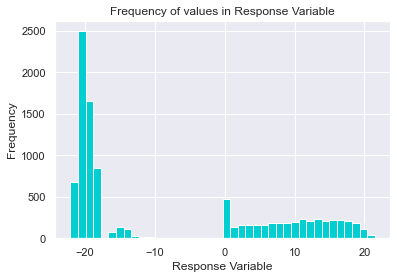

In [3]:
# draw the distribution of Y
plt.hist(Y['y'].values, color='darkturquoise', bins=40)
plt.xlabel('Response Variable')
plt.ylabel('Frequency')
plt.title("Frequency of values in Response Variable")
plt.show()

In [4]:
########### Data Cleanup #############
# drop if y == 0.0
drop_if_y_equals_to_0 = True
if drop_if_y_equals_to_0:
    drop_idx = Y[Y['y'] == 0].index
    X = X.drop(drop_idx)
    Y = Y.drop(drop_idx)
    
# drop if -15 < y < 0
drop_interstitial = True
if drop_interstitial:
    drop = Y['y'].between(-15, 0, inclusive=False)
#     print(Y['y'], drop)
    X = X[~drop]
    Y = Y[~drop]
    
# binarize data for rows with |Y| >= 15
binarize_15 = True
if binarize_15:
    y_mask = 1 * ~(abs(Y['y']) >= 15)
    Y['y_bin'] = [1 if a == 1 else 0 for a in y_mask]
    print(Y)

      Unnamed: 0          y  y_bin
0              0  15.274658      0
1              1  11.586073      1
2              2   8.149087      1
3              3 -21.094292      0
5              5 -21.080594      0
...          ...        ...    ...
9927        9927   9.939726      1
9928        9928 -18.913927      0
9929        9929 -18.877169      0
9930        9930 -19.683105      0
9931        9931  17.938584      0

[9278 rows x 3 columns]


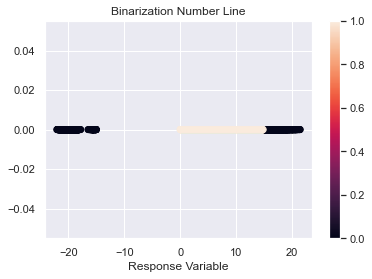

In [5]:
plt.scatter(Y['y'].values, [0] * Y.shape[0], c=Y['y_bin'])
plt.xlabel('Response Variable')
plt.title("Binarization Number Line")
plt.colorbar()
plt.show()

In [6]:
# data split
X = X.drop(columns='Unnamed: 0')
X['Sex'] = X['Sex'].replace({1: 'Male', 2: 'Female'})
X['Race'] = X['Race'].replace({1: 'White', 2: 'Other', 3: 'Black'})
sex_dummies = pd.get_dummies(X['Sex'], prefix='Sex')
race_dummies = pd.get_dummies(X['Race'], prefix='Race')
dfs = [X, sex_dummies, race_dummies]
X = pd.concat(dfs, axis=1)
X = X.drop(columns=['Sex', 'Race'])

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=108)

print(x_train.shape)
print(x_test.shape)

(6958, 21)
(2320, 21)


In [7]:
y_train = y_train['y_bin'].copy()
y_test = y_test['y_bin'].copy()

In [8]:
# x_train, y_train, x_test, y_test can be used for further evaluation

In [32]:
# Define the imputation method

def knn_imputer(x_train, x_test, x_val):
    imputer_ = KNNImputer(n_neighbors=30)
    xtr = imputer_.fit_transform(x_train, y_train)
    xte = imputer_.transform(x_test)
    xval = imputer_.transform(x_val)
    
    return xtr, xte, xval

def descriptive_stats_model(model, xte, yte):
    test_acc = model.score(xte, yte)
    y_pred_test = model.predict(xte)
    y_prob = model.predict_proba(xte)
    cm = confusion_matrix(y_pred_test, y_test, labels=[1,0])
    TP, FP, FN, TN = cm.ravel()
    print(classification_report(y_test, y_pred_test))
    FNR = FN / (FN + TP)
    FPR = FP / (FP + TN)
    b_loss = brier_score_loss(yte, y_prob[:,1])
    return_dict = {'accuracy': test_acc,
                  'con_matrix': cm,
                  'FNR': FNR,
                  'FPR': FPR,
                  'brier_loss': b_loss}
    return return_dict

In [10]:
xtr, xte, xval = knn_imputer(x_train, x_test, x_train)

In [114]:
%%time
# Function to create model, required for KerasClassifier
def create_model(n1=1, n2=1, lr=0.1):

    model = tf.keras.Sequential()
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n1, activation='relu'))
    model.add(Dense(n2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    adam = tf.keras.optimizers.Adam(lr=lr) 
    model.compile(loss='BinaryCrossentropy', optimizer=adam, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=1, epochs=50, batch_size=10)

# define the grid search parameters

n1 = [10, 20, 30]
n2 = [10, 20, 30]
batch_size = [16, 32, 64]
epochs = [100]
lr = [0.001, 0.01, 0.1]
param_grid = dict(n1=n1, n2=n2, batch_size=batch_size, epochs=epochs, lr=lr)

grid = GridSearchCV(estimator=model, scoring='roc_auc', param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xtr, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/100
109/109 [==============================] - 0s 869us/step - loss: 0.9689 - accuracy: 0.7226
Epoch 2/100
109/109 [==============================] - 0s 842us/step - loss: 0.4821 - accuracy: 0.7669
Epoch 3/100
109/109 [==============================] - 0s 823us/step - loss: 0.4622 - accuracy: 0.7746
Epoch 4/100
109/109 [==============================] - 0s 805us/step - loss: 0.4500 - accuracy: 0.7805
Epoch 5/100
109/109 [==============================] - 0s 805us/step - loss: 0.4397 - accuracy: 0.7849
Epoch 6/100
109/109 [==============================] - 0s 842us/step - loss: 0.4380 - accuracy: 0.7900
Epoch 7/100
109/109 [==============================] - 0s 833us/step - loss: 0.4318 - accuracy: 0.7963
Epoch 8/100
109/109 [==============================] - 0s 814us/step - loss: 0.4324 - accuracy: 0.7889
Epoch 9/100
109/109 [==============================] - 0s 833us/step - loss: 0.4263 - accuracy: 0.7978
Epoch 10/100
109/109 [==============================] - 0s 833us/step - l

109/109 [==============================] - 0s 787us/step - loss: 0.4036 - accuracy: 0.8116
Epoch 80/100
109/109 [==============================] - 0s 796us/step - loss: 0.4029 - accuracy: 0.8070
Epoch 81/100
109/109 [==============================] - 0s 869us/step - loss: 0.4000 - accuracy: 0.8145
Epoch 82/100
109/109 [==============================] - 0s 759us/step - loss: 0.3989 - accuracy: 0.8061
Epoch 83/100
109/109 [==============================] - 0s 869us/step - loss: 0.4090 - accuracy: 0.7997
Epoch 84/100
109/109 [==============================] - 0s 833us/step - loss: 0.4027 - accuracy: 0.8104
Epoch 85/100
109/109 [==============================] - 0s 814us/step - loss: 0.4033 - accuracy: 0.8107
Epoch 86/100
109/109 [==============================] - 0s 952us/step - loss: 0.4024 - accuracy: 0.8116
Epoch 87/100
109/109 [==============================] - 0s 915us/step - loss: 0.4019 - accuracy: 0.8143
Epoch 88/100
109/109 [==============================] - 0s 814us/step - loss:

In [115]:
train_acc = grid_result.best_estimator_.score(xtr, y_train)
test_acc = grid_result.best_estimator_.score(xte, y_test)

print("Training Accuracy: {:.4f}".format(train_acc))
print("Testing Accuracy: {:.4f}".format(test_acc))

37/37 [==============================] - 0s 674us/step - loss: 0.4092 - accuracy: 0.8013
Training Accuracy: 0.8165
Testing Accuracy: 0.8013


In [116]:
final = KerasClassifier(build_fn=create_model, n1=30,n2=20,lr=0.01, verbose=0, epochs=100, batch_size=64)

final.fit(xtr, y_train)

In [117]:
matrix = descriptive_stats_model(final, xte, y_test)
matrix

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1692
           1       0.65      0.58      0.61       628

    accuracy                           0.80      2320
   macro avg       0.75      0.73      0.74      2320
weighted avg       0.79      0.80      0.80      2320



{'accuracy': 0.8008620738983154,
 'con_matrix': array([[ 363,  197],
        [ 265, 1495]], dtype=int64),
 'FNR': 0.42197452229299365,
 'FPR': 0.11643026004728133,
 'brier_loss': 0.13441681535343825}

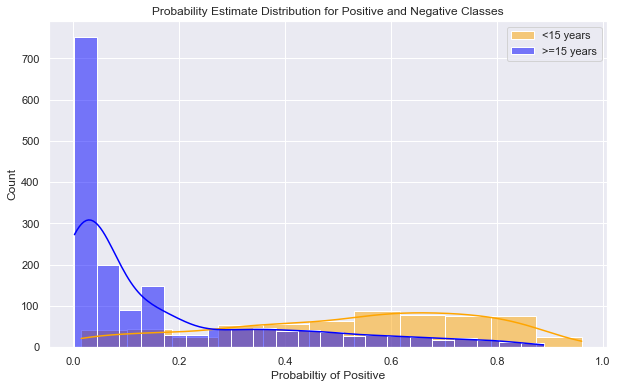

In [118]:
predict_prob = final.predict_proba(xte)
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(predict_prob[y_test == 1][:,1], color = 'orange', kde=True, label="<15 years")
sns.histplot(predict_prob[y_test == 0][:,1], color = 'blue', kde=True, label='>=15 years')
ax.set(xlabel="Probabiltiy of Positive", 
       title='Probability Estimate Distribution for Positive and Negative Classes')
ax.legend()
plt.show()

In [60]:
#!pip install shap

In [61]:
import shap
shap.initjs()

In [119]:
explainer = shap.KernelExplainer(final.predict, xtr[:50,:])
shap_values = explainer.shap_values(xte[0,:], nsamples=500)

In [120]:
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test.iloc[0,:])

In [121]:
explainer = shap.KernelExplainer(final.predict, xtr[:50,:])
shap_values = explainer.shap_values(xte[:50,:])
shap.force_plot(explainer.expected_value, shap_values[0], xte[:50,:], feature_names=x_train.columns)